# Génération des embeddings CORD-19

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import sys
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
class EmbeddingsGenerator:
    def __init__(self, model_name):
        from sentence_transformers import SentenceTransformer
        import torch
        self.model = SentenceTransformer(model_name, device="cuda" if torch.cuda.is_available() else "cpu")
    def prepare_texts(self, df, max_length=512):
        s = (df['title'].fillna('') + ' ' + df['abstract'].fillna('')).str.strip()
        return s.str.slice(0, max_length).tolist()
    def generate_embeddings(self, texts, batch_size=64, show_progress=True):
        import numpy as np
        emb = self.model.encode(texts, batch_size=batch_size, show_progress_bar=show_progress, normalize_embeddings=False)
        return np.asarray(emb, dtype=np.float32)
    def analyze_embeddings(self, embeddings, sample_size=1000):
        import numpy as np
        n = min(sample_size, embeddings.shape[0])
        rng = np.random.RandomState(42)
        idx = rng.choice(embeddings.shape[0], n, replace=False)
        sub = embeddings[idx]
        sims = cosine_similarity(sub[:200], sub[:200])
        return {"shape": embeddings.shape, "mean_norm": float(np.linalg.norm(embeddings, axis=1).mean()), "sample_sim_mean": float(np.nanmean(sims))}
    def visualize_embeddings(self, embeddings, df, sample_size=2000):
        import numpy as np
        n = min(sample_size, embeddings.shape[0])
        rng = np.random.RandomState(42)
        idx = rng.choice(embeddings.shape[0], n, replace=False)
        sub = embeddings[idx]
        tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="random")
        xy = tsne.fit_transform(sub)
        plt.figure(figsize=(10,8))
        plt.scatter(xy[:,0], xy[:,1], s=3, alpha=0.5)
        plt.title("t-SNE des embeddings")
        plt.tight_layout()
        plt.show()
        return xy
    def save_embeddings(self, embeddings, df, output_dir):
        import numpy as np
        from pathlib import Path
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        np.save(output_dir/'embeddings.npy', embeddings)
        meta = {"num_rows": int(df.shape[0]), "dim": int(embeddings.shape[1])}
        with open(output_dir/'embeddings_metadata.json','w',encoding='utf-8') as f:
            json.dump(meta, f, ensure_ascii=False, indent=2)
        df[['title','abstract']].to_csv(output_dir/'articles_for_embeddings.csv', index=False)
        return str(output_dir/'embeddings.npy')


In [5]:
BASE_PATH = Path("../data/processed")
OUTPUT_DIR = BASE_PATH
MODEL_NAME = 'all-MiniLM-L6-v2'
BATCH_SIZE = 64
MAX_LENGTH = 512
SAMPLE_SIZE = None


In [6]:
print("📂 Chargement des données...")
fallback1 = BASE_PATH / 'cleaned_articles.csv'
fallback2 = BASE_PATH / 'articles_with_communities.csv'
if fallback1.exists():
    df = pd.read_csv(fallback1, low_memory=False)
elif fallback2.exists():
    df = pd.read_csv(fallback2, low_memory=False)
else:
    raise FileNotFoundError('Aucun fichier de données trouvé dans data/processed')
print(f"✅ {len(df):,} articles chargés")
if SAMPLE_SIZE and len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
print(f"📦 Dataset utilisé: {len(df):,} articles")
df[['title','abstract']].head(2)


📂 Chargement des données...
✅ 816,359 articles chargés
📦 Dataset utilisé: 816,359 articles


,title,abstract
0,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...
1,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...


In [7]:
generator = EmbeddingsGenerator(model_name=MODEL_NAME)
texts = generator.prepare_texts(df, max_length=MAX_LENGTH)
len(texts)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

816359

In [8]:
embeddings = generator.generate_embeddings(texts, batch_size=BATCH_SIZE, show_progress=True)
embeddings.shape


Batches:   0%|          | 0/12756 [00:00<?, ?it/s]

(816359, 384)

In [9]:
generator.analyze_embeddings(embeddings, sample_size=1000)


{'shape': (816359, 384),
 'mean_norm': 1.0,
 'sample_sim_mean': 0.1529606729745865}

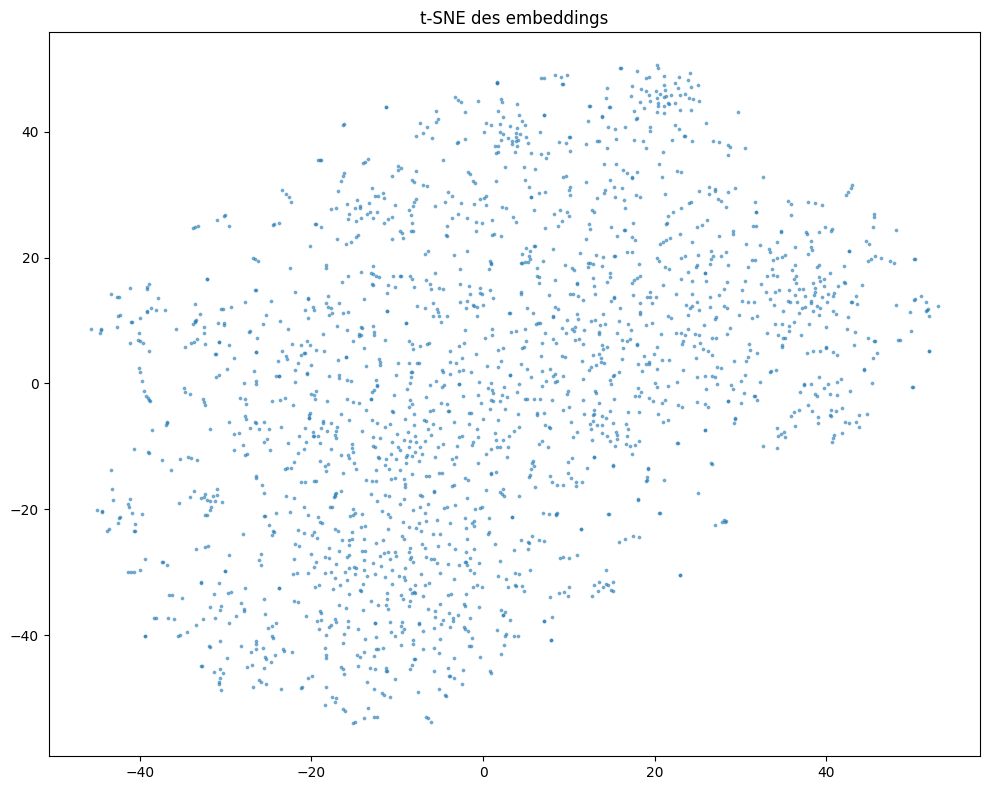

array([[-29.040699 ,   4.0795503],
       [ 45.680714 ,   6.6915107],
       [ 22.315195 ,  41.051994 ],
       ...,
       [ 10.066939 , -27.689722 ],
       [  2.376956 ,  -8.976289 ],
       [ 21.029448 ,  22.519606 ]], shape=(2000, 2), dtype=float32)

In [10]:
generator.visualize_embeddings(embeddings, df, sample_size=2000)


In [11]:
generator.save_embeddings(embeddings, df, OUTPUT_DIR)
list(OUTPUT_DIR.glob('*embeddings*.n*'))


[WindowsPath('../data/processed/embeddings.npy')]